#  library

main() 함수 내 crawler() 함수 수행

In [24]:
 # -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
"""
fname = '한국행정구역분류_2022.1.1.기준.xlsx'
data_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})
data_region[1].drop('Unnamed: 0', axis=1, inplace=True)
data_citydo_all = data_region[1]['시도'][1:]
data_citydo_unique = data_citydo_all.unique()
booleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]
data_citydo_unique_notna = data_citydo_unique[booleanArray1]
data_citydo_unique_notna
data_citygungu_all = data_region[1]['시군구'][1:]
data_citygungu_unique = data_citygungu_all.unique()
data_citygungu_unique
"""

"\nfname = '한국행정구역분류_2022.1.1.기준.xlsx'\ndata_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})\ndata_region[1].drop('Unnamed: 0', axis=1, inplace=True)\ndata_citydo_all = data_region[1]['시도'][1:]\ndata_citydo_unique = data_citydo_all.unique()\nbooleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]\ndata_citydo_unique_notna = data_citydo_unique[booleanArray1]\ndata_citydo_unique_notna\ndata_citygungu_all = data_region[1]['시군구'][1:]\ndata_citygungu_unique = data_citygungu_all.unique()\ndata_citygungu_unique\n"

# 크롤링

- 크롤링 해오는 것 : 링크,제목,신문사,내용요약본
- 키워드 : 붉은물, 적수, 유충


- 내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장

In [26]:
cos = []

In [130]:
flag_save = 0

maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  # 1
sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") # 0

s_date = '2019.08.08' # 2019.05.10  2019.05.20  2019.05.30  2019.06.09  2019.06.19  2019.06.29  2019.07.09  2019.07.19  2019.07.29  2019.08.08
e_date = '2019.08.17' # 2019.05.19  2019.05.29  2019.06.08  2019.06.18  2019.06.28  2019.07.08  2019.07.18  2019.07.28  2019.08.07  2019.08.17

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='C:/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

#크롤링 시작
list_region = ['인천']

for region in list_region:
  list_keyword = ['수돗물적수']
  for keyword in list_keyword:
    query = region +' ' + keyword
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
        atags = soup.find_all('a', 'news_tit')
        for atag in atags:
            title = atag.get('title')
            title_text.append(title)     #제목
            link_text.append(atag['href'])   #링크주소

        #신문사 추출 (a 태그 중 class 명이 info press인 것)
        source_lists = soup.find_all('a', 'info press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사

        #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
        contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화

        #모든 리스트 딕셔너리형태로 저장
        result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
        df = pd.DataFrame(result)  #df로 변환
        page += 10
        print(df)

if flag_save == 1:
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s %s시 %s분 %s초 merging' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(outputFileName+'.xlsx',sheet_name='sheet1')
    #df.to_csv(outputFileName+'.csv', mode='w')

최대 크롤링할 페이지 수 입력하시오: 100
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
                                       title      source  \
0             붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                        수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2              포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3           인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4               '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
5          인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수        경향신문   
6               인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐        중부일보   
7  인천시의회, '붉은 수돗물' 특위...탁도계 업체 "탁도계 고장 사실아냐"        경인방송   
8                        인천시, 수돗물 적수 피해보상 착수      파이낸셜뉴스   
9        인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈        한국경제   

                                            contents  \
0  주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1  적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   
2  막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...   
3  인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...

                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
5                   인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수        경향신문   
6                        인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐        중부일보   
7           인천시의회, '붉은 수돗물' 특위...탁도계 업체 "탁도계 고장 사실아냐"        경인방송   
8                                 인천시, 수돗물 적수 피해보상 착수      파이낸셜뉴스   
9                 인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈        한국경제   
10                 '적수피해보상' 현장 접수처 182곳… 인천시 행정공백 불가피        경인일보   
11                    인천 수돗물 수질기준 위반, 시민 알리기 '의무화' 추진       인천투데이   
12               [티브로드]<인천> 서구 주민, 수돗물 피해 손해 배상 소송 추진     SK브로드밴드   
13                 인천시 단수민원 피하려다… 

                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
5                   인천 '붉은 수돗물' 피해보상…사흘간 2333명 4억원 접수        경향신문   
6                        인천시의회 특위, 붉은 수돗물 조사 호통치기에 그쳐        중부일보   
7           인천시의회, '붉은 수돗물' 특위...탁도계 업체 "탁도계 고장 사실아냐"        경인방송   
8                                 인천시, 수돗물 적수 피해보상 착수      파이낸셜뉴스   
9                 인천 붉은 수돗물 피해주민들 “피해보상 청구서가 서약서냐” 발끈        한국경제   
10                 '적수피해보상' 현장 접수처 182곳… 인천시 행정공백 불가피        경인일보   
11                    인천 수돗물 수질기준 위반, 시민 알리기 '의무화' 추진       인천투데이   
12               [티브로드]<인천> 서구 주민, 수돗물 피해 손해 배상 소송 추진     SK브로드밴드   
13                 인천시 단수민원 피하려다… 

                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
75                        파주, 경기도 상수도 위기관리대응 평가 ‘S등급’        신아일보   
76             [한눈에 보는 전국 이슈] 8월 12일 전국 주요신문 1면 뉴스 요약      뉴스인사이드   
77           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


                                                title      source  \
0                      붉은 수돗물 피해 주민들 "정상화 아냐"…집단소송 예고  연합뉴스언론사 선정   
1                                 수돗물 적수 이어 이번엔 역한 냄새      파이낸셜뉴스   
2                       포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시       NSP통신   
3                    인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수         뉴스1   
4                        '적수 사태 진상규명' 인천시의회 특위 행정사무조사        경인일보   
..                                                ...         ...   
78       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
79  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   
80           TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭        시선뉴스   
81       샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위       더드라이브   
82  [데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...        데일리안   

                                             contents  \
0   주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...   
1   적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...   


In [131]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
dfNew = pd.Series(list_search)
df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)

corpus = df_tfidf_base
corpus

C:\Users\qpflw\AppData\Local\Temp/ipykernel_36764/123471369.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)


0     주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...
1     적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...
2     막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...
3     인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...
4     13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...
                            ...                        
79    인천 서구 수돗물 정상화 민·관 대책위원회 주민대책위는 11일 인천시청 브리핑룸에서...
80    최근 인천시를 중심으로 발생한 수돗물 적수현상이 서울, 경기지역까지 확산되면서 큰 ...
81    최근 인천 서구에서 시작되어 전국적으로 확산되고 있는 적수 이슈와 이와 함께 녹물,...
82    인천 서구 수돗물 정상화 민·관 대책위원회 주민대책위는 11일 인천시청 브리핑룸에서...
83                                             인천 수돗물적수
Length: 84, dtype: object

In [132]:
df

,title,source,contents,link
0,"붉은 수돗물 피해 주민들 ""정상화 아냐""…집단소송 예고",연합뉴스언론사 선정,"주민대책위, 인천시 발표 보상 계획 철회·재논의 요구 '인천 붉은 수돗물'(적수) ...",http://yna.kr/AKR20190811025500065?did=1195m
1,수돗물 적수 이어 이번엔 역한 냄새,파이낸셜뉴스,적수 수돗물로 피해를 줬던 인천지역 수돗물에서 이번에는 흙냄새와 곰팡이 냄새가 발생...,http://www.fnnews.com/news/201908131312234449
2,"포항시, 수돗물 여과 실험 및 상수도관 이토작업 실시",NSP통신,막여과 시험이란 수돗물 1리터를 공극 0.45㎛ 여과지에 걸러서 여과된 상태(변색 ...,http://www.nspna.com/news/?mode=view&newsid=37...
3,인천 '붉은 수돗물' 피해보상 착수…12~30일 신청 접수,뉴스1,인천시가 ‘붉은 수돗물’(적수) 피해보상 절차에 착수한다. 시는 오는 12~30일 ...,http://news1.kr/articles/?3691442
4,'적수 사태 진상규명' 인천시의회 특위 행정사무조사,경인일보,13일 오전 인천시의회에서 열린 '수돗물 적수 사고 행정사무조사'에서 전·현직 상수...,http://www.kyeongin.com/main/view.php?key=2019...
...,...,...,...,...
78,"샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위",더드라이브,"최근 인천 서구에서 시작되어 전국적으로 확산되고 있는 적수 이슈와 이와 함께 녹물,...",http://www.thedrive.co.kr/news/newsview.php?nc...
79,"[데일리안 오늘뉴스 종합] 日 수출규제 피해기업 지원, DHC 혐한 방송 파문···...",데일리안,인천 서구 수돗물 정상화 민·관 대책위원회 주민대책위는 11일 인천시청 브리핑룸에서...,http://www.dailian.co.kr/news/view/817318/?sc=...
80,"TS트릴리온, TS내추럴스파 비타민 샤워기필터 오는 12일 홈앤쇼핑 론칭",시선뉴스,"최근 인천시를 중심으로 발생한 수돗물 적수현상이 서울, 경기지역까지 확산되면서 큰 ...",http://www.sisunnews.co.kr/news/articleView.ht...
81,"샤워기 필터 헤드 닥터피엘, 욕실용품 샤워 영역 네이버 베스트 상품 100 1위",더드라이브,"최근 인천 서구에서 시작되어 전국적으로 확산되고 있는 적수 이슈와 이와 함께 녹물,...",http://www.thedrive.co.kr/news/newsview.php?nc...


# 벡터화

In [133]:
tfidfv = TfidfVectorizer().fit(corpus)
tfidfv_array = tfidfv.transform(corpus).toarray()

In [134]:
tfidfv_array

array([[0.12771918, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.1770066 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16884932, 0.        , 0.14704643, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# 유사도

In [135]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidfv_array, tfidfv_array)) 
cos_sim_df

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,1.000000,0.038063,0.027024,0.117355,0.043250,0.043364,0.036902,0.018825,0.048187,0.025865,...,0.019327,0.046486,0.092888,0.004604,0.046688,0.277461,0.004604,0.046688,0.277461,0.038193
1,0.038063,1.000000,0.017400,0.018065,0.034315,0.070005,0.018730,0.028237,0.017906,0.023746,...,0.011459,0.000000,0.004906,0.008550,0.005489,0.005991,0.008550,0.005489,0.005991,0.000000
2,0.027024,0.017400,1.000000,0.005873,0.022913,0.020459,0.020853,0.003010,0.005821,0.001620,...,0.018007,0.043446,0.006855,0.022814,0.007670,0.008372,0.022814,0.007670,0.008372,0.000000
3,0.117355,0.018065,0.005873,1.000000,0.012959,0.080499,0.006322,0.008120,0.095940,0.055248,...,0.002861,0.069962,0.013082,0.002135,0.018287,0.019959,0.002135,0.018287,0.019959,0.000000
4,0.043250,0.034315,0.022913,0.012959,1.000000,0.013815,0.033955,0.124681,0.012845,0.008871,...,0.005807,0.005030,0.026601,0.027941,0.032363,0.024691,0.027941,0.032363,0.024691,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.277461,0.005991,0.008372,0.019959,0.024691,0.013908,0.014176,0.029152,0.028045,0.019141,...,0.012776,0.011068,0.042442,0.003043,0.038479,1.000000,0.003043,0.038479,1.000000,0.025246
80,0.004604,0.008550,0.022814,0.002135,0.027941,0.011502,0.002320,0.004071,0.002116,0.021857,...,0.034563,0.003384,0.002492,1.000000,0.091414,0.003043,1.000000,0.091414,0.003043,0.000000
81,0.046688,0.005489,0.007670,0.018287,0.032363,0.017384,0.017719,0.012197,0.026934,0.022007,...,0.033847,0.037105,0.039361,0.091414,1.000000,0.038479,0.091414,1.000000,0.038479,0.046261
82,0.277461,0.005991,0.008372,0.019959,0.024691,0.013908,0.014176,0.029152,0.028045,0.019141,...,0.012776,0.011068,0.042442,0.003043,0.038479,1.000000,0.003043,0.038479,1.000000,0.025246


In [136]:
len_contents = len(cos_sim_df)-1
len_contents

83

In [137]:
cos_sim_df_sorted = cos_sim_df.iloc[len_contents].sort_values(ascending=False)
cos_sim_df_sorted

83    1.000000
36    0.062016
76    0.062016
66    0.062016
56    0.062016
        ...   
30    0.000000
29    0.000000
61    0.000000
27    0.000000
13    0.000000
Name: 83, Length: 84, dtype: float64

In [138]:
cos_sim_df_sorted_others = cos_sim_df_sorted[1:]
cos_sim_df_sorted_others

cos_sim_df_sorted_others_sum = cos_sim_df_sorted_others.sum()/10 * 100 # percent 지표
print(cos_sim_df_sorted_others_sum)

15.49148692305148


In [139]:
cos.append(cos_sim_df_sorted_others_sum)
cos

[0.0,
 0.0,
 13.133226280390486,
 23.480172836049544,
 11.7067519093039,
 11.039304055767255,
 13.571027493972048,
 11.739404924588518,
 10.475083176234316,
 15.49148692305148]

In [140]:
cos_df = pd.DataFrame(cos)
cos_df

,0
0,0.000000
1,0.000000
2,13.133226
3,23.480173
4,11.706752
5,11.039304
6,13.571027
7,11.739405
8,10.475083
9,15.491487


# 시각화

In [141]:
plt.rc("font", family="Malgun Gothic") # window

Text(0.5, 1.0, '네이버 코사인 유사도(%)')

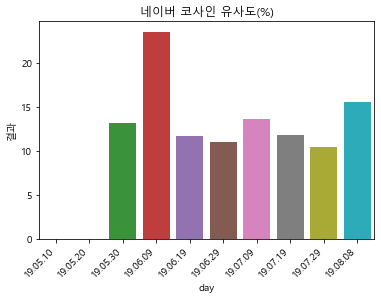

In [142]:
df1=pd.DataFrame({'day':('19.05.10','19.05.20','19.05.30','19.06.09','19.06.19','19.06.29', '19.07.09', '19.07.19', '19.07.29', '19.08.08'),'결과':cos})
p = sns.barplot(data = df1, x ='day',y='결과')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
p.set_title("네이버 코사인 유사도(%)")